# Ex-fuzzy para la detección y disminución de sesgos - Ejemplo 2: Supervivencia de pacientes con fallos cardiacos

Autores:


Raquel Fernandez Peralta - Slovak Academy of Sciences

Javier Fumanal Idocin - University of Essex, Yufe Fellow

En este ejemplo, utilizamos un modelo basado en reglas borrosas para predecir la supervivencia de pacientes con fallos cardiacos y analizamos las reglas obtenidas según el género. Además, investigamos si los resultados presentan sesgo de precisión diferencial.

## 1. Instalación e importación de paquetes

Primero de todo instalamos la librería ex-fuzzy y descargamos las bases de datos que vamos a utilizar en este tutorial.

In [1]:
!pip install git+https://github.com/Fuminides/ex-fuzzy.git
!git clone https://github.com/Fuminides/WorkshopIgualdad2025.git
!pip install fairlearn

  Cloning https://github.com/Fuminides/ex-fuzzy.git to /tmp/pip-req-build-aj8jnvfm
  Running command git clone --filter=blob:none --quiet https://github.com/Fuminides/ex-fuzzy.git /tmp/pip-req-build-aj8jnvfm
  Resolved https://github.com/Fuminides/ex-fuzzy.git to commit 97baf4a1c6fa813481322d1fc8a60d075dfcf38a
  Preparing metadata (setup.py) ... done
fatal: destination path 'WorkshopIgualdad2025' already exists and is not an empty directory.


A continuación, importamos los demas paquetes de Python que vamos a utilizar en el tutorial.

In [2]:
import pandas as pd
import numpy as np
from docutils.nodes import legend
import ex_fuzzy.fuzzy_sets as fs
import ex_fuzzy.evolutionary_fit as GA
import ex_fuzzy.utils as  utils
import ex_fuzzy.eval_tools as eval_tools
import ex_fuzzy.vis_rules as vis_rules
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier
from matplotlib.patches import Patch
from fairlearn.metrics import MetricFrame
from imblearn.under_sampling import RandomUnderSampler

## 2. Algunas funciones que nos van a ser útiles

Para simplificar el tutorial, hemos implementado algunas funciones básicas que simplificaran algunas ejecuciones más adelante.

In [3]:
def compute_metrics(y_test, y_pred, model_name="Model"):
    """
    Calcula y muestra métricas de evaluación de un modelo de clasificación,
    incluyendo una visualización de la matriz de confusión.

    Args:
        y_test: Valores reales
        y_pred: Predicciones del modelo
        model_name: Nombre del modelo para mostrar en los gráficos

    Returns:
        Diccionario con las métricas calculadas
    """
    # Calcular métricas
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    # Imprimir métricas con formato profesional
    print(f"\n=== {model_name} Evaluation Metrics ===")
    print(f"{'Accuracy:':<12} {metrics['Accuracy']:.4f}")
    print(f"{'F1 Score:':<12} {metrics['F1']:.4f}")
    print(f"{'Recall:':<12} {metrics['Recall']:.4f}")

    # Visualización de la matriz de confusión
    print("\n=== Confusion Matrix ===")

    # Configurar el estilo de seaborn
    sns.set(style="white")
    plt.figure(figsize=(5, 4))  # Reduced figure size from (8,6) to (5,4)

    # Crear heatmap de la matriz de confusión
    ax = sns.heatmap(metrics['Confusion Matrix'],
                     annot=True,
                     fmt="d",
                     cmap="Blues",
                     cbar=False,
                     annot_kws={"size": 12})  # Reduced annotation size from 14 to 12

    # Configuraciones adicionales del gráfico
    plt.title(f"{model_name} - Confusion Matrix", fontsize=14, pad=15)  # Reduced font sizes
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    ax.xaxis.set_ticklabels(['Negative', 'Positive'], fontsize=10)  # Reduced font size
    ax.yaxis.set_ticklabels(['Negative', 'Positive'], fontsize=10)  # Reduced font size

    plt.tight_layout()
    plt.show()

    return metrics

def generar_mascara_categorica(X, verbose=True):
    """
    Genera una máscara que indica el número de clases únicas para cada columna categórica.

    Parámetros:
    -----------
    X : pandas.DataFrame
        DataFrame de entrada a analizar
    verbose : bool, opcional
        Si True, imprime información sobre las clases únicas (por defecto True)

    Retorna:
    --------
    numpy.ndarray
        Array donde cada posición representa una columna del DataFrame:
        - 0 para columnas no categóricas
        - Número de clases únicas para columnas categóricas
    """
    # Verificar que el input sea un DataFrame usando la forma recomendada
    if not hasattr(X, 'columns') or not hasattr(X, 'dtypes'):
        raise TypeError("El argumento X debe ser un pandas DataFrame o similar")

    # Inicializar la máscara con ceros
    categorical_mask = np.zeros(X.shape[1], dtype=int)

    # Iterar sobre cada columna
    for i, column in enumerate(X.columns):
        # Verificar si la columna es categórica usando métodos actualizados
        col_dtype = X[column].dtype
        if is_object_dtype(col_dtype) or isinstance(col_dtype, CategoricalDtype):
            # Obtener clases únicas (maneja valores nulos adecuadamente)
            unique_classes = X[column].dropna().unique()
            categorical_mask[i] = len(unique_classes)

            # Mostrar información si verbose=True
            if verbose:
                # Manejar correctamente tipos numéricos en categorías
                try:
                    sorted_classes = sorted(unique_classes.tolist())
                except TypeError:
                    sorted_classes = unique_classes.tolist()
                print(f"Columna '{column}' - Clases únicas ({len(unique_classes)}): {sorted_classes}")

    return categorical_mask

def extract_rules_from_text(str_rules):
    """
    Extracts rule parts from a formatted rules text.

    Args:
        str_rules (str): String containing rules separated by newlines,
                        with possible headers and separators.

    Returns:
        list: A collection of cleaned rule parts (before 'WITH' keyword).
    """
    rule_collection = []
    consequent = -1
    for rule_cand in str_rules.splitlines():
        rule_cand = rule_cand.strip()  # Clean whitespace
        if rule_cand.startswith('Rules for consequent'):
            consequent = consequent +1
        else:
            if not (rule_cand.startswith('Rules for consequent') or rule_cand.startswith('------')) and rule_cand:
                # Split at 'WITH' and take the part before it
                rule_part = rule_cand.split('WITH')[0].strip()
                if rule_part:  # Ensure it's not empty after splitting
                    rule_part = rule_part + ' THEN ' + str(consequent)
                    rule_collection.append(rule_part)
    return rule_collection

## 3. Carga, exploracion y limpieza de los datos

Primero de todo, cargamos el dataset 'heart_failure.csv' que se puede encontrar en (https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data). Este dataset contiene información médica sobre pacientes con insuficiencia cardíaca, incluyendo sus características demográficas, signos vitales, y si fallecieron durante el período de estudio.

In [4]:
df = pd.read_csv('./WorkshopIgualdad2025/heart_failure.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,death
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1


Mostramos información general del dataset, como tipos de datos y valores no nulos.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  death                     299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.2 KB


Este dataset, tiene las siguientes variables:

- **age**: Edad del paciente (años)
- **anaemia**: Disminución de glóbulos rojos o hemoglobina (0 = no, 1 = sí)
- **creatinine_phosphokinase**: Nivel de la enzima CPK en sangre (mcg/L)
- **diabetes**: Si el paciente tiene diabetes (0 = no, 1 = sí)
- **ejection_fraction**: Porcentaje de sangre que sale del corazón en cada contracción (%)
- **high_blood_pressure**: Si el paciente tiene hipertensión (0 = no, 1 = sí)
- **platelets**: Plaquetas en la sangre (kiloplaquetas/mL)
- **serum_creatinine**: Nivel de creatinina sérica en sangre (mg/dL)
- **serum_sodium**: Nivel de sodio sérico en sangre (mEq/L)
- **sex**: Género del paciente (0 = mujer, 1 = hombre)
- **smoking**: Si el paciente fuma (0 = no, 1 = sí)
- **death**: Si el paciente falleció durante el período de seguimiento (0 = no, 1 = sí)

En este caso, podemos ver que no tenemos datos faltantes.

Mostramos estadísticas descriptivas de las columnas numéricas del dataset.

In [6]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,death
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,1.00000


A continuación, hacemos un gráfico de barras que muestra el porcentaje de supervivencia por género.

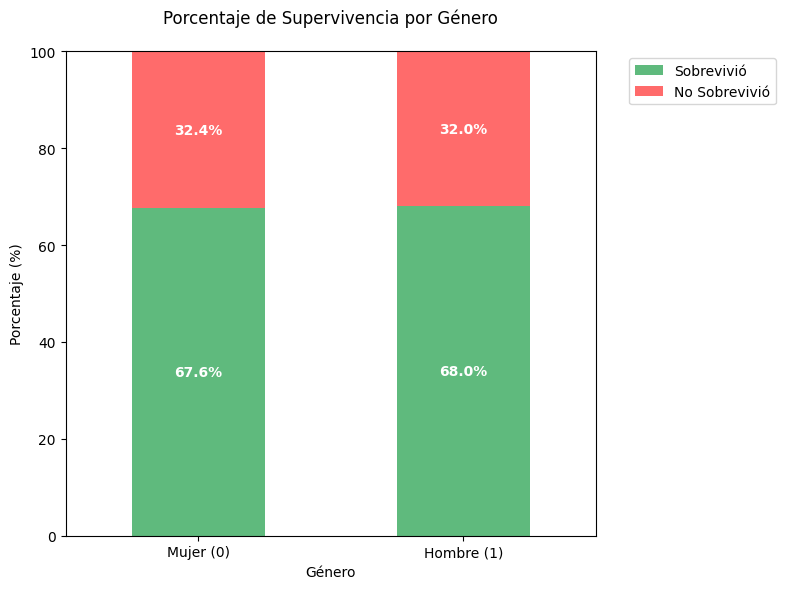

In [7]:
# Calcular los porcentajes
survival_pct = df.groupby(['sex', 'death']).size().unstack()
survival_pct = survival_pct.div(survival_pct.sum(axis=1), axis=0) * 100
# Crear el gráfico
ax = survival_pct.plot(kind='bar',
                      stacked=True,
                      color=['#5fba7d','#ff6b6b'],
                      figsize=(8, 6))
plt.title('Porcentaje de Supervivencia por Género', pad=20)
plt.xlabel('Género')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)

# Personalizar etiquetas del eje X (0 = Mujer, 1 = Hombre)
ax.set_xticklabels(['Mujer (0)', 'Hombre (1)'])  # Orden: 0 primero, 1 después

plt.legend(['Sobrevivió','No Sobrevivió'], bbox_to_anchor=(1.05, 1))
plt.ylim(0, 100)
# Añadir etiquetas de porcentaje
for i, (gender, row) in enumerate(survival_pct.iterrows()):
    # Parte inferior (No sobrevivió)
    ax.text(i, row[0]/2, f"{row[0]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold')

    # Parte superior (Sobrevivió)
    ax.text(i, row[0] + row[1]/2, f"{row[1]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold')
# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [8]:
df2 = df.copy()

In [9]:
X = df2.drop(columns=['death'])
y = df2['death'].to_numpy()

In [10]:
X.dtypes

,0
age,float64
anaemia,int64
creatinine_phosphokinase,int64
diabetes,int64
ejection_fraction,int64
high_blood_pressure,int64
platelets,float64
serum_creatinine,float64
serum_sodium,int64
sex,int64


Asignamos a cada variable el tipo que le corresponde. Este paso es necesario para una correcta codificación de las variables categóricas.

In [11]:
X['anaemia'] = X['anaemia'].astype(object)
X['diabetes'] = X['diabetes'].astype(object)
X['high_blood_pressure'] = X['high_blood_pressure'].astype(object)
X['sex'] = X['sex'].astype(object)
X['smoking'] = X['smoking'].astype(object)

Para no tener que lidiar que la clasificación no balanceada, para este ejemplo concreto eliminamos de manera aleatoria instancias de la clase mayoritaria (supervivientes).

In [12]:
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

Con un diagrama de barras, nos aseguramos que ahora las clases están balanceadas.

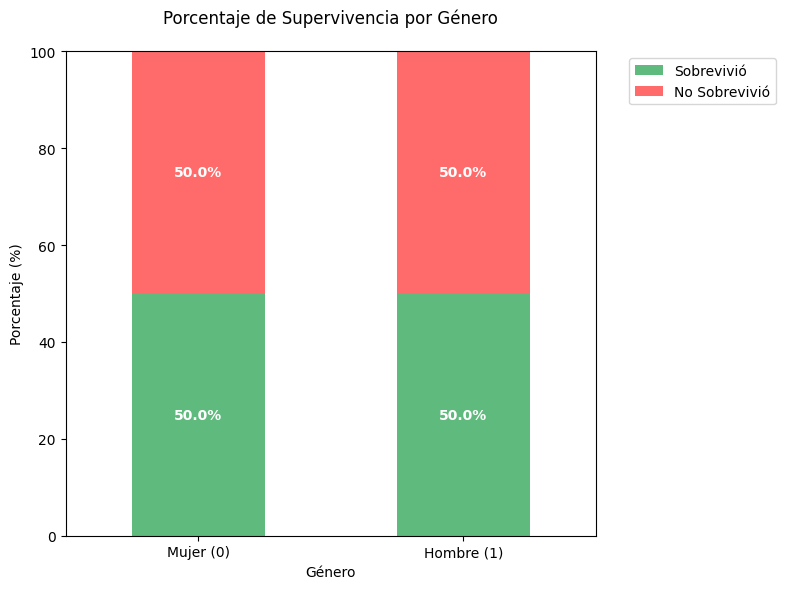

In [13]:
survival_df = pd.DataFrame({'sex': X['sex'], 'death': y})
survival_pct = survival_df.groupby(['sex', 'death']).size().unstack()
survival_pct = survival_pct.div(survival_pct.sum(axis=1), axis=0) * 100

# Crear el gráfico
ax = survival_pct.plot(kind='bar',
                      stacked=True,
                      color=['#5fba7d','#ff6b6b'],  # Rojo: No Sobrevivió, Verde: Sobrevivió
                      figsize=(8, 6))
plt.title('Porcentaje de Supervivencia por Género', pad=20)
plt.xlabel('Género')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)

# Personalizar etiquetas del eje X (0 = Mujer, 1 = Hombre)
ax.set_xticklabels(['Mujer (0)', 'Hombre (1)'])  # Orden: 0 primero, 1 después

# Leyenda
plt.legend(['Sobrevivió','No Sobrevivió'], bbox_to_anchor=(1.05, 1))
plt.ylim(0, 100)

# Añadir etiquetas de porcentaje
for i, (gender, row) in enumerate(survival_pct.iterrows()):
    # Parte inferior (No sobrevivió)
    ax.text(i, row[1]/2, f"{row[1]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold')

    # Parte superior (Sobrevivió)
    ax.text(i, row[1] + row[0]/2, f"{row[0]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

Finalmente, hacemos un diagrama de barras para saber el % de hombres y mujeres en el dataset resultante.

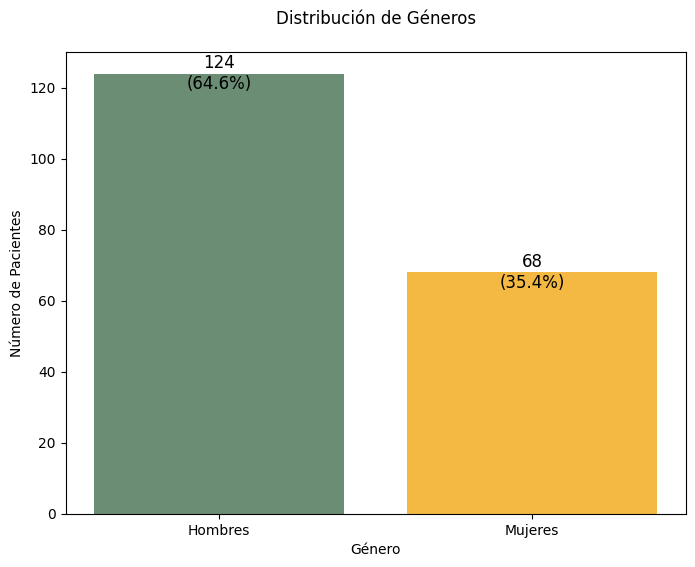

In [14]:
gender_counts = X['sex'].value_counts()
gender_percent = gender_counts / gender_counts.sum() * 100

# Mapear los valores de género a etiquetas
labels = {0: 'Mujeres', 1: 'Hombres'}
gender_counts.index = gender_counts.index.map(labels)
gender_percent.index = gender_percent.index.map(labels)


colors = ['#6a8d73', '#f4b942']  # Verde tierra y amarillo mostaza

# Crear el gráfico
plt.figure(figsize=(8, 6))
bars = plt.bar(gender_counts.index, gender_counts.values, color=colors)


plt.title('Distribución de Géneros', pad=20)
plt.xlabel('Género')
plt.ylabel('Número de Pacientes')

# Añadir los porcentajes en las barras
for bar, count, percent in zip(bars, gender_counts.values, gender_percent.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({percent:.1f}%)',
             ha='center', va='center', fontsize=12)

plt.show()

## 4. Entrenamos un clasificador basado en reglas con ex-fuzzy

Primero de todo, separamos la base de datos en conjunto de entrenamiento y validación. En este caso, guardamos también la distribución de géneros en cada muestra.

In [15]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, X['sex'],test_size=0.33, random_state=42)

Creamos un vector que nos indique qué variables son categóricas y cuántas clases tiene dicha variable.

In [16]:
categorical_mask = generar_mascara_categorica(X,verbose=True)

Columna 'anaemia' - Clases únicas (2): [0, 1]
Columna 'diabetes' - Clases únicas (2): [0, 1]
Columna 'high_blood_pressure' - Clases únicas (2): [0, 1]
Columna 'sex' - Clases únicas (2): [0, 1]
Columna 'smoking' - Clases únicas (2): [0, 1]


Entrenamos el clasficador basado en reglas borrosas.

In [17]:
fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=10, # Número máximo de reglas
                                           nAnts=3, # Número máximo de variables que pueden aparecen en el antecedent de las reglas
                                           fuzzy_type=fs.FUZZY_SETS.t1, # Tipo de conjunto borroso a utilizar
                                           tolerance=0.0, # Tolerancia mínima a considerar. Podemos aumentar este límite si no queremos obtener reglas con un mínimo de calidad.
                                           n_linguistic_variables=3, # Número de etiquetas linguisticas que queremos en la fuzzificación de las variables numéricas.
                                           verbose = True, # Si True, se imprime por pantalla los resultados obtenidos luego de cada iteración.
                                           linguistic_variables=None, #Si indicamos None se inicializan los pesos con los quantiles y luego se optimizan para obtener una mejor clasificación. Si indicamos una partición concreta entonces esta quedará fija.
                                           categorical_mask = categorical_mask, # Máscara de variables categóricas.
                                           ds_mode=2, # El clasificador tiene 3 modos diferentes según los pesos que queramos asignar a cada regla -> Si se establece en 0, se utilizan las puntuaciones de dominancia como pesos; si se establece en 1, todos los pesos se configuran en 1; y si se establece en 2, se ignorarán las puntuaciones de dominancia y los pesos se establecerán mediante la optimización genética.
                                           allow_unknown=False # Si True, permite cada regla devolver -1 para indicar que la clase a asignar es desconocida.
                                            )
fl_classifier.fit(X_train,
                  y_train,
                  n_gen=100, # Número de iteraciones
                  pop_size=50, # Número de individuos a considerar en cada iteración
                  random_state=42)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 |  0.9683553053 |  0.6032357745
     2 |      100 |  0.8671491109 |  0.6032357745
     3 |      150 |  0.7668418407 |  0.6032357745
     4 |      200 |  0.6567801895 |  0.6032357745
     5 |      250 |  0.6205260531 |  0.6032357745
     6 |      300 |  0.6028149989 |  0.5882944423
     7 |      350 |  0.6023385672 |  0.5882944423
     8 |      400 |  0.6003662989 |  0.5786205701
     9 |      450 |  0.5951238705 |  0.5786205701
    10 |      500 |  0.5875932307 |  0.5708054930
    11 |      550 |  0.5840610594 |  0.5708054930
    12 |      600 |  0.5805848756 |  0.5677115929
    13 |      650 |  0.5745428155 |  0.5473576226
    14 |      700 |  0.5669016016 |  0.5263898339
    15 |      750 |  0.5611573659 |  0.5263898339
    16 |      800 |  0.5494227234 |  0.5263898339
    17 |      850 |  0.5359246320 |  0.5090410729
    18 |      900 |  0.5237701957 |  0.5090410729
    19 |      950 |  0.5196059260 |  0.5090410729


In [18]:
rule_base = fl_classifier.get_rulebase()
fl_evaluator = eval_tools.FuzzyEvaluator(fl_classifier)
str_rules = fl_evaluator.eval_fuzzy_model(X_train, y_train, X_test, y_test,
                        plot_rules=False, print_rules=True, plot_partitions=False, return_rules=True)

------------
ACCURACY
Train performance: 0.828125
Test performance: 0.734375
------------
MATTHEW CORRCOEF
Train performance: 0.6565310641181111
Test performance: 0.48541506429795983
------------
Rules for consequent: 0
----------------
IF creatinine_phosphokinase IS Low AND platelets IS Medium AND serum_creatinine IS Low WITH DS 0.031732459362893296, ACC 1.0, WGHT 0.85
IF anaemia IS 1 AND diabetes IS 1 AND sex IS 1 WITH DS 0.0362548828125, ACC 0.8333333333333334, WGHT 0.46
IF serum_creatinine IS Low WITH DS 0.14227830840320121, ACC 0.8064516129032258, WGHT 0.87

Rules for consequent: 1
----------------
IF diabetes IS 1 AND ejection_fraction IS Low WITH DS 0.05318854312469572, ACC 0.85, WGHT 0.66
IF age IS Low AND diabetes IS 0 AND sex IS 1 WITH DS 0.015631323367817324, ACC 1.0, WGHT 0.55
IF creatinine_phosphokinase IS Low AND platelets IS Low AND sex IS 0 WITH DS 0.030764896439852866, ACC 1.0, WGHT 0.46
IF diabetes IS 0 AND ejection_fraction IS Low WITH DS 0.07049849379259981, ACC 0.7


=== Model Evaluation Metrics ===
Accuracy:    0.7344
F1 Score:    0.7213
Recall:      0.6471

=== Confusion Matrix ===


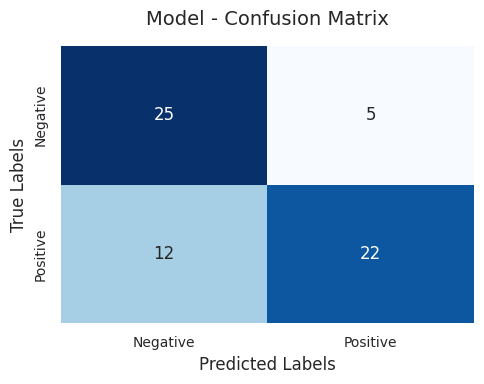

In [19]:
y_pred = fl_evaluator.fl_classifier.predict(X_test)
metrics = compute_metrics(y_test, y_pred)

### 4.1 Explicación por paciente


En esta sección, utilizaremos la base de reglas obtenida con el algoritmo para dar una explicación de la clasificación hecha para cada paciente.

Primero de todo, extraemos cada regla como un string de texto.

In [20]:
rule_collection = extract_rules_from_text(str_rules)
rule_collection

['IF creatinine_phosphokinase IS Low AND platelets IS Medium AND serum_creatinine IS Low THEN 0',
 'IF anaemia IS 1 AND diabetes IS 1 AND sex IS 1 THEN 0',
 'IF serum_creatinine IS Low THEN 0',
 'IF diabetes IS 1 AND ejection_fraction IS Low THEN 1',
 'IF age IS Low AND diabetes IS 0 AND sex IS 1 THEN 1',
 'IF creatinine_phosphokinase IS Low AND platelets IS Low AND sex IS 0 THEN 1',
 'IF diabetes IS 0 AND ejection_fraction IS Low THEN 1',
 'IF age IS High AND anaemia IS 0 THEN 1']

Ahora, podemos usar la función *explainable_predict* para extraer la clase asginada a cada ejemplo, la regla utilizada para decidir dicha clase y el nivel de verdad correspondiente. Notad que para este paso hemos considerado todo el dataset y no solo el conjunto de validación.

In [21]:
explainable_predict = fl_classifier.explainable_predict(X)
class_assigned = explainable_predict[0]
fired_rules = explainable_predict[1]
membership_degree = explainable_predict[2]

In [22]:
results_instance = pd.DataFrame({
    'sex': X['sex'].values.ravel(),  #
    'death': y,  #
    'fired_Rule': [rule_collection[i] for i in np.array(fired_rules).ravel()],
    'consequent': np.array(class_assigned).ravel(),
    'membership': np.array(membership_degree).ravel()
})
results_instance.head(10)

,sex,death,fired_Rule,consequent,membership
0,1,0,IF anaemia IS 1 AND diabetes IS 1 AND sex IS 1...,0.0,1.000000
1,0,0,IF serum_creatinine IS Low THEN 0,0.0,0.386197
2,1,0,IF serum_creatinine IS Low THEN 0,0.0,0.914357
3,0,0,IF serum_creatinine IS Low THEN 0,0.0,0.804324
4,0,0,IF serum_creatinine IS Low THEN 0,0.0,0.584257
5,1,0,IF anaemia IS 1 AND diabetes IS 1 AND sex IS 1...,0.0,1.000000
6,1,0,IF serum_creatinine IS Low THEN 0,0.0,0.474224
7,1,0,IF serum_creatinine IS Low THEN 0,0.0,1.000000
8,0,0,IF serum_creatinine IS Low THEN 0,0.0,0.804324
9,0,0,IF serum_creatinine IS Low THEN 0,0.0,0.474224


Si además queremos entender para cada ejemplo porqué a ganado cada regla podemos utilizar la función 'predict_proba' para obtener el nivel de verdad de cada regla para cada paciente.

In [23]:
rule_memberships = fl_evaluator.fl_classifier.predict_proba(X)
n_rules = rule_memberships.shape[1]
data = {
    'sex': X['sex'].values.ravel(),
    'rule_selected': np.array(fired_rules).ravel()
}
for rule_idx in range(n_rules):
    data[f'rule {rule_idx}'] = rule_memberships[:, rule_idx].ravel()
results = pd.DataFrame(data)
results

,sex,rule_selected,rule 0,rule 1,rule 2,rule 3,rule 4,rule 5,rule 6,rule 7
0,1,1,0.000000,1.0,0.000000,0.065433,0.0,0.000000,0.000000,0.000000
1,0,2,0.073866,0.0,0.386197,0.000000,0.0,0.066431,0.000000,0.000000
2,1,2,0.286590,0.0,0.914357,0.000000,0.0,0.000000,0.000000,0.000000
3,0,2,0.000000,0.0,0.804324,0.000000,0.0,0.336508,0.335930,0.000000
4,0,2,0.000000,0.0,0.584257,0.335930,0.0,0.469841,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
187,1,6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.137736
188,0,6,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.786758,0.000000
189,1,6,0.158625,0.0,0.474224,0.000000,0.0,0.000000,1.000000,0.000000
190,1,3,0.000000,1.0,0.144124,1.000000,0.0,0.000000,0.000000,0.000000


### 4.2 Explicación por género

Como cada paciente tiene asignada una regla, podemos hacer el histograma del % de pacientes asignados a cada regla por género. Esto no solo nos está indicando qué reglas són más significativas, si no que nos ayuda a entender si el algoritmo se está comportando de manera uniforme según el género o no.

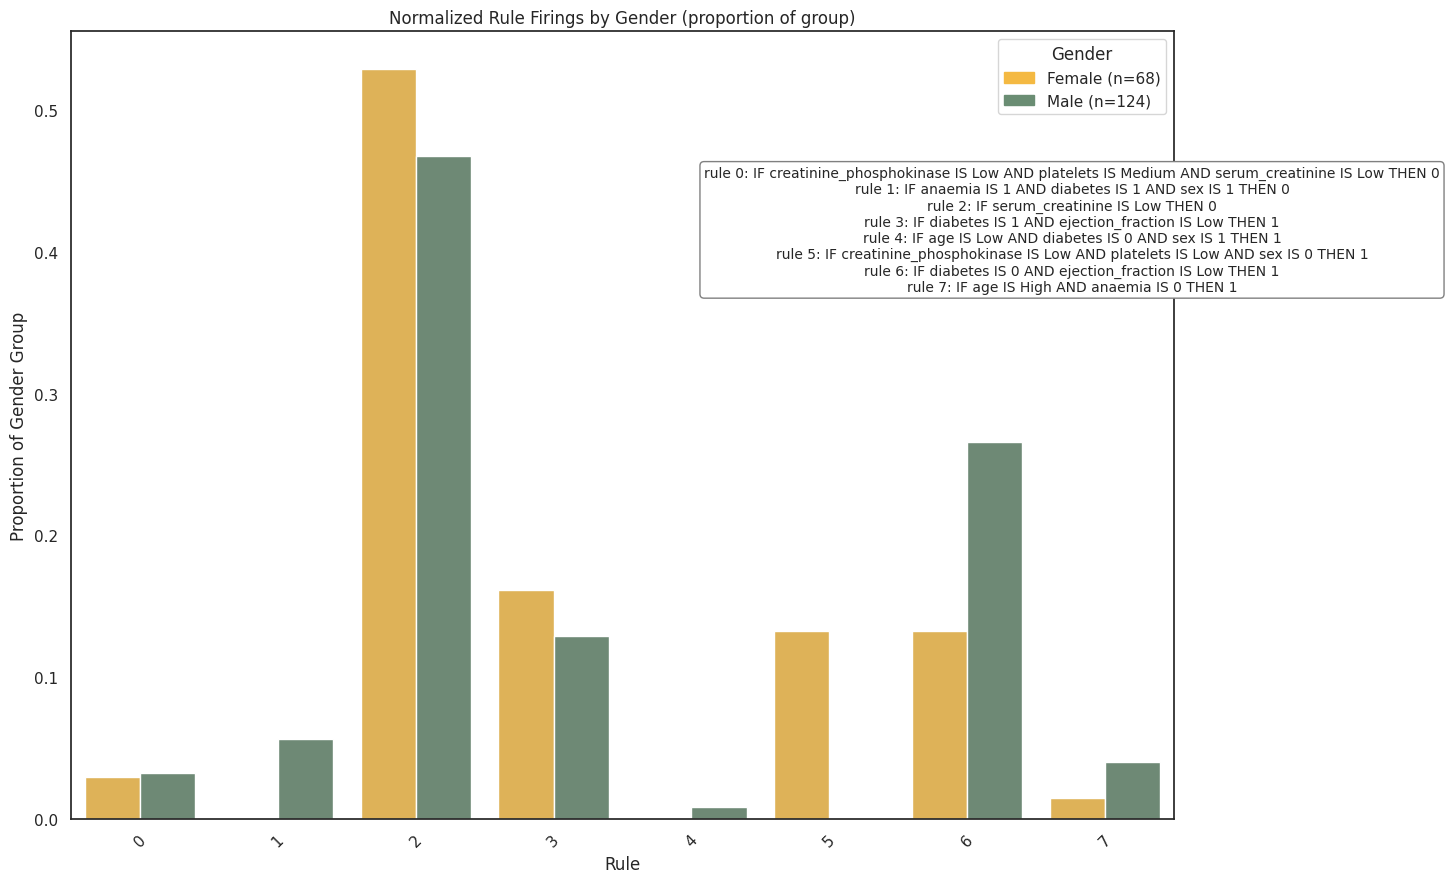

In [24]:
# Step 1: Count rule firings by gender and get total counts per gender
rule_firing_counts = (
    results.groupby(['sex', 'rule_selected'])
    .size()
    .reset_index(name='count')
)

# Get total counts per gender
total_counts = results['sex'].value_counts().to_dict()

# Normalize the counts by total per gender
rule_firing_counts['normalized_count'] = rule_firing_counts.apply(
    lambda row: row['count'] / total_counts[row['sex']],
    axis=1
)

# Step 2: Fix gender dtype
rule_firing_counts['sex'] = rule_firing_counts['sex'].astype(str)  # Ensure 'sex' is strings
palette = {'0': '#f4b942', '1': '#6a8d73'}

# Rule list
rules = rule_collection
rule_labels = [f'rule {i}' for i in range(len(rules))]  # Generate rule0, rule1, ...

# Step 3: Plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    data=rule_firing_counts,
    x='rule_selected',
    y='normalized_count',  # Use normalized count instead of raw count
    hue='sex',
    palette=palette,
    hue_order=['0', '1']
)
plt.title('Normalized Rule Firings by Gender (proportion of group)')
plt.xlabel('Rule')
plt.ylabel('Proportion of Gender Group')
plt.xticks(rotation=45)

# Step 4: Manually Create and Set Custom Legend
legend_colors = {'0': '#f4b942', '1': '#6a8d73'}
handles = [Patch(color=legend_colors[key], label=f"{label} (n={total_counts[int(key)]})")
           for key, label in zip(legend_colors.keys(), ['Female', 'Male'])]
plt.legend(title='Gender', handles=handles)

# Adjust figure size to be taller
fig.set_size_inches(12, 10)

# Add rule list below the plot (centered)
rule_text = '\n'.join([f"{label}: {rule}" for label, rule in zip(rule_labels, rules)])
plt.figtext(
    0.9,  # x position (center)
    0.7,  # y position (just below plot)
    rule_text,
    ha='center',  # horizontal alignment
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray')
)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at bottom
plt.show()

### 4.3 Estudiando el sesgo por género


Ahora, estudiaremos el modelo presenta una precisión diferente entre grupos (como hombres y mujeres). Esto se conoce como sesgo de precisión diferencial.

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>,
        <Axes: title={'center': 'mcc'}, xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>,
        <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>,
        <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>,
        <Axes: xlabel='sex'>]], dtype=object)

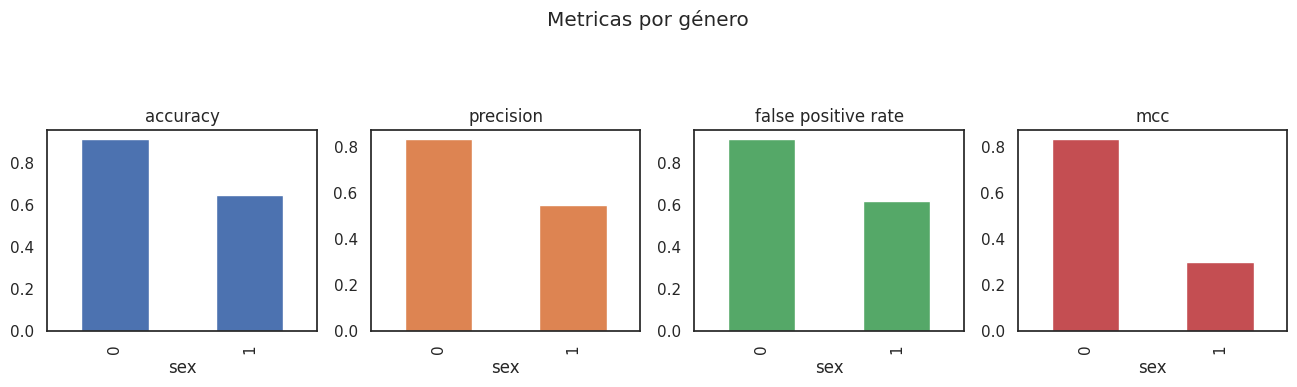

In [25]:
metrics = {"accuracy": accuracy_score,"precision": recall_score,"false positive rate": f1_score,"mcc": matthews_corrcoef}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=A_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[4, 4],
    legend=False,
    figsize=[16, 12],
    title="Metricas por género",
)

Curiosamente, aunque el número de mujeres en el dataset era menor al de los hombres, se obtiene una mayor precisión al predecir la muerte por fallo cardiaco en las mujeres. Este sesgo se debe a que las poblaciones de ambos géneros no presentan las mismas características, por ejemplo podemos ver como hay muchos más hombres fumadores que mujeres, por lo tanto en este dataset particular la población de mujeres podría ser más homogénea y por lo tanto más fácil de clasificar. Para reducir este sesgo, se pueden considerar técnicas de disminución de sesgos como veremos en el Ejemplo 3.

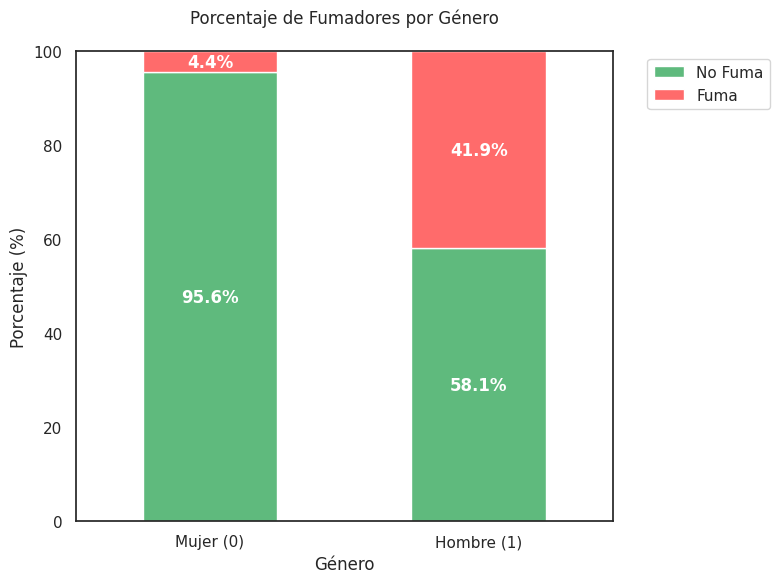

In [26]:
# Crear DataFrame con género y hábito de fumar
smoke_df = pd.DataFrame({'sex': X['sex'], 'smoke': X['smoking']})

# Calcular porcentajes
smoke_pct = smoke_df.groupby(['sex', 'smoke']).size().unstack()
smoke_pct = smoke_pct.div(smoke_pct.sum(axis=1), axis=0) * 100

# Crear el gráfico
ax = smoke_pct.plot(kind='bar',
                   stacked=True,
                   color=['#5fba7d','#ff6b6b'],  # Verde: No Fuma, Rojo: Fuma
                   figsize=(8, 6))

plt.title('Porcentaje de Fumadores por Género', pad=20)
plt.xlabel('Género')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)

# Personalizar etiquetas del eje X
ax.set_xticklabels(['Mujer (0)', 'Hombre (1)'])

# Leyenda (invertida para coincidir con el orden de las barras)
plt.legend(['No Fuma', 'Fuma'], bbox_to_anchor=(1.05, 1))
plt.ylim(0, 100)

# Añadir etiquetas de porcentaje
for i, (gender, row) in enumerate(smoke_pct.iterrows()):
    # Parte inferior (No Fuma)
    ax.text(i, row[0]/2, f"{row[0]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold')

    # Parte superior (Fuma)
    ax.text(i, row[0] + row[1]/2, f"{row[1]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()